# Check linearity

In [102]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import os
from itertools import product
import numpy as np
import xarray as xr
import dask

import matplotlib.pyplot as plt
import cartopy

import cmocean

import box_model
import glodap
import util
import co2calc

Set ocean state

In [104]:
dic_range = np.arange(1900.0, 2300.0, 10.0)
alk_range = np.arange(2300.0, 2550.0, 10.0)
delta_alk_range = np.arange(1., 101.0, 10.0)

ni = len(alk_range)
nj = len(dic_range)
nk = len(delta_alk_range)

coords = dict(
    dic=xr.DataArray(dic_range, name="dic", dims=("dic")),
    alk=xr.DataArray(alk_range, name="alk", dims=("alk")),
    delta_alk=xr.DataArray(delta_alk_range, name="delta_alk", dims=("delta_alk")),
)

ds = xr.Dataset(
    data_vars=dict(
        eta=xr.DataArray(
            np.empty((nk, nj, ni)), name="eta", dims=("delta_alk", "dic", "alk")
        ),
        ddicdco2=xr.DataArray(
            np.empty((nk, nj, ni)), name="ddicdco2", dims=("delta_alk", "dic", "alk")
        ),
        dtau_dalk=xr.DataArray(
            np.empty((nj, ni)), name="dtau_dalk", dims=("dic", "alk")
        ),
        deta_dalk=xr.DataArray(
            np.empty((nj, ni)), name="deta_dalk", dims=("dic", "alk")
        ),
    ),
    coords=coords,
)
ds

<xarray.Dataset>
Dimensions:    (alk: 25, delta_alk: 10, dic: 40)
Coordinates:
  * dic        (dic) float64 1.9e+03 1.91e+03 1.92e+03 ... 2.28e+03 2.29e+03
  * alk        (alk) float64 2.3e+03 2.31e+03 2.32e+03 ... 2.53e+03 2.54e+03
  * delta_alk  (delta_alk) float64 1.0 11.0 21.0 31.0 ... 61.0 71.0 81.0 91.0
Data variables:
    eta        (delta_alk, dic, alk) float64 1.132e-310 1.132e-310 ... nan nan
    ddicdco2   (delta_alk, dic, alk) float64 1.132e-310 1.132e-310 ... 0.0 0.0
    dtau_dalk  (dic, alk) float64 4.663e-310 1.132e-310 ... 4.663e-310
    deta_dalk  (dic, alk) float64 1.132e-310 4.663e-310 ... 0.2052 1.0

In [105]:
cluster, client = util.get_ClusterClient(memory="12GB")
cluster.scale(128)
client

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44357 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eyankovsky/proxy/44357/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eyankovsky/proxy/44357/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:33855,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/eyankovsky/proxy/44357/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [106]:
obj = box_model.calc_csys(
    dic_range[0], alk_range[0], salt=35.0, temp=20.0, flavor="pyco2sys"
)


@dask.delayed
def compute_eta(dic, alk, delta_alk):
    obj.solve_co2(dic, alk)
    delta_dic = obj.calc_new_dic_w_oae(alk + delta_alk) - dic

    return delta_dic / delta_alk, np.nanmean([obj.ddicdco2(dic, alk + delta_alk),obj.ddicdco2(dic + delta_dic, alk + delta_alk)])


del_objs = []
for k, delta_alk in enumerate(delta_alk_range):
    for j, dic in enumerate(dic_range):
        for i, alk in enumerate(alk_range):
            del_objs.append(compute_eta(dic, alk, delta_alk))

computed_objs = dask.compute(*del_objs)

n = 0
for k, delta_alk in enumerate(delta_alk_range):
    for j, dic in enumerate(dic_range):
        for i, alk in enumerate(alk_range):
            eta, ddicdco2 = computed_objs[n]
            ds.eta[k, j, i] = eta
            ds.ddicdco2[k, j, i] = ddicdco2

            n += 1

obj = box_model.calc_csys(
    dic_range[0], alk_range[0], salt=35.0, temp=20.0, flavor="pyco2sys"
)


In [107]:
print('done')

done


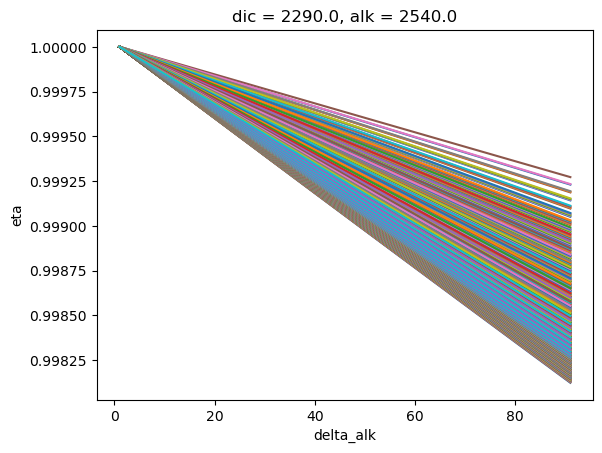

In [108]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        (ds.eta.isel(dic=j, alk=i) / ds.eta.isel(delta_alk=0, dic=j, alk=i)).plot()

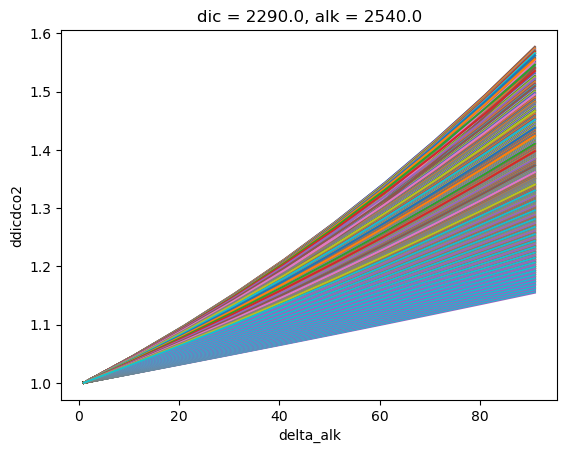

In [109]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        #(ds.ddicdco2.isel(dic=j, alk=i)).plot()
        (ds.ddicdco2.isel(dic=j, alk=i) / ds.ddicdco2.isel(delta_alk=0, dic=j, alk=i)).plot()

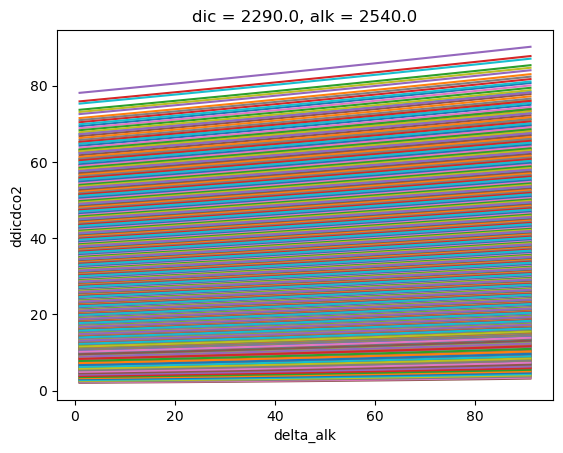

In [110]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        (ds.ddicdco2.isel(dic=j, alk=i) ).plot()

In [111]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        m, b = np.polyfit(ds.delta_alk, ds.eta.isel(dic=j, alk=i), 1)
        ds.deta_dalk[j, i] = 100.0 * m

In [112]:
for j, dic in enumerate(dic_range):
    for i, alk in enumerate(alk_range):
        m, b = np.polyfit(
            ds.delta_alk,
            ds.ddicdco2.isel(dic=j, alk=i)
            / ds.ddicdco2.isel(delta_alk=0, dic=j, alk=i),
            1,
        )
        ds.dtau_dalk[j, i] = 100.0 * m

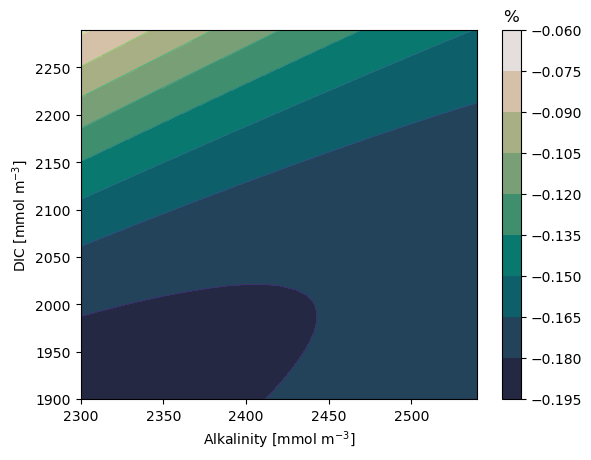

In [113]:
cf = plt.contourf(
    ds.alk,
    ds.dic,
    100 * (ds.eta[-1, :, :] - ds.eta[0, :, :]) / ds.eta[0, :, :],
    cmap=cmocean.cm.rain_r,
)
plt.contour(
    ds.alk,
    ds.dic,
    100 * (ds.eta[-1, :, :] - ds.eta[0, :, :]) / ds.eta[0, :, :],
    linewidths=0.5,
)
cb = plt.colorbar(cf)
cb.ax.set_title("%")
plt.xlabel("Alkalinity [mmol m$^{-3}$]")
plt.ylabel("DIC [mmol m$^{-3}$]");

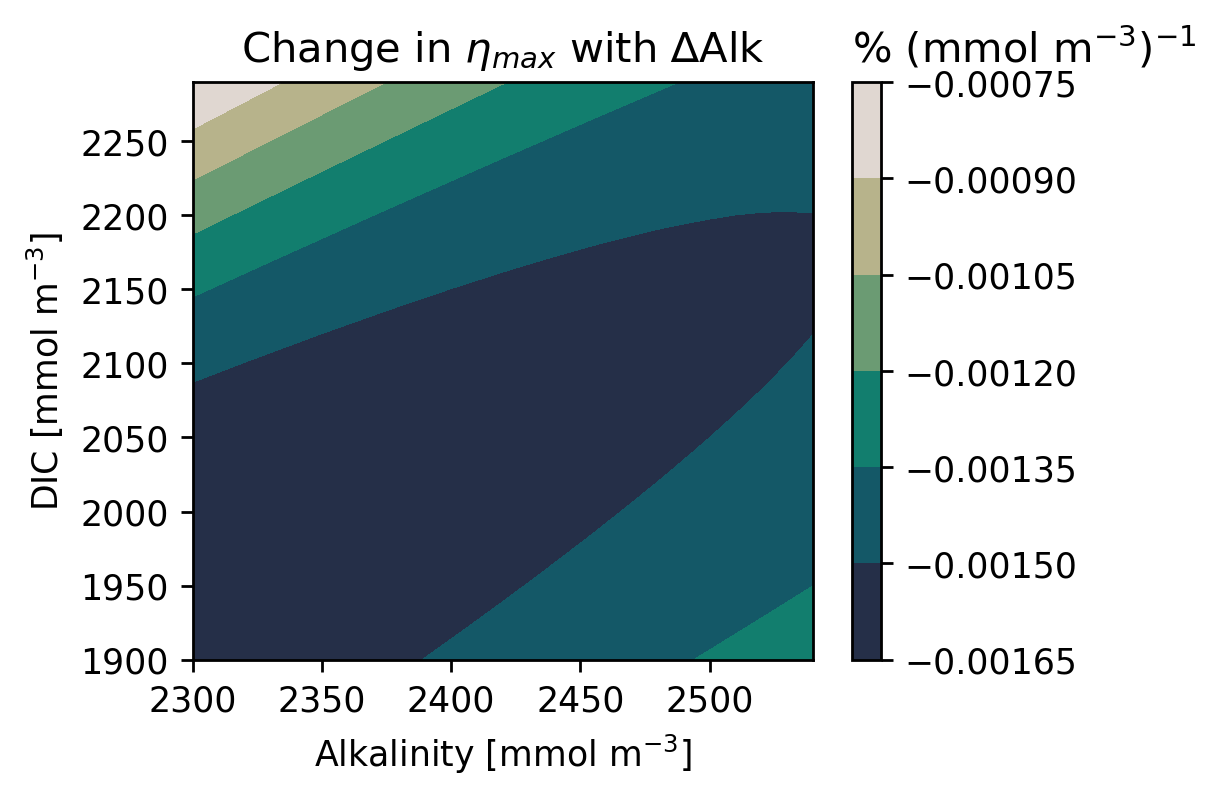

In [114]:
plt.figure(figsize=(4,3),dpi=250)
cf = plt.contourf(
    ds.alk,
    ds.dic,
    ds.deta_dalk,
    cmap=cmocean.cm.rain_r,
)
cb = plt.colorbar(cf)
cb.ax.set_title("% (mmol m$^{-3}$)$^{-1}$", loc="left")
plt.xlabel("Alkalinity [mmol m$^{-3}$]")
plt.ylabel("DIC [mmol m$^{-3}$]")
plt.title("Change in $\eta_{max}$ with ∆Alk");

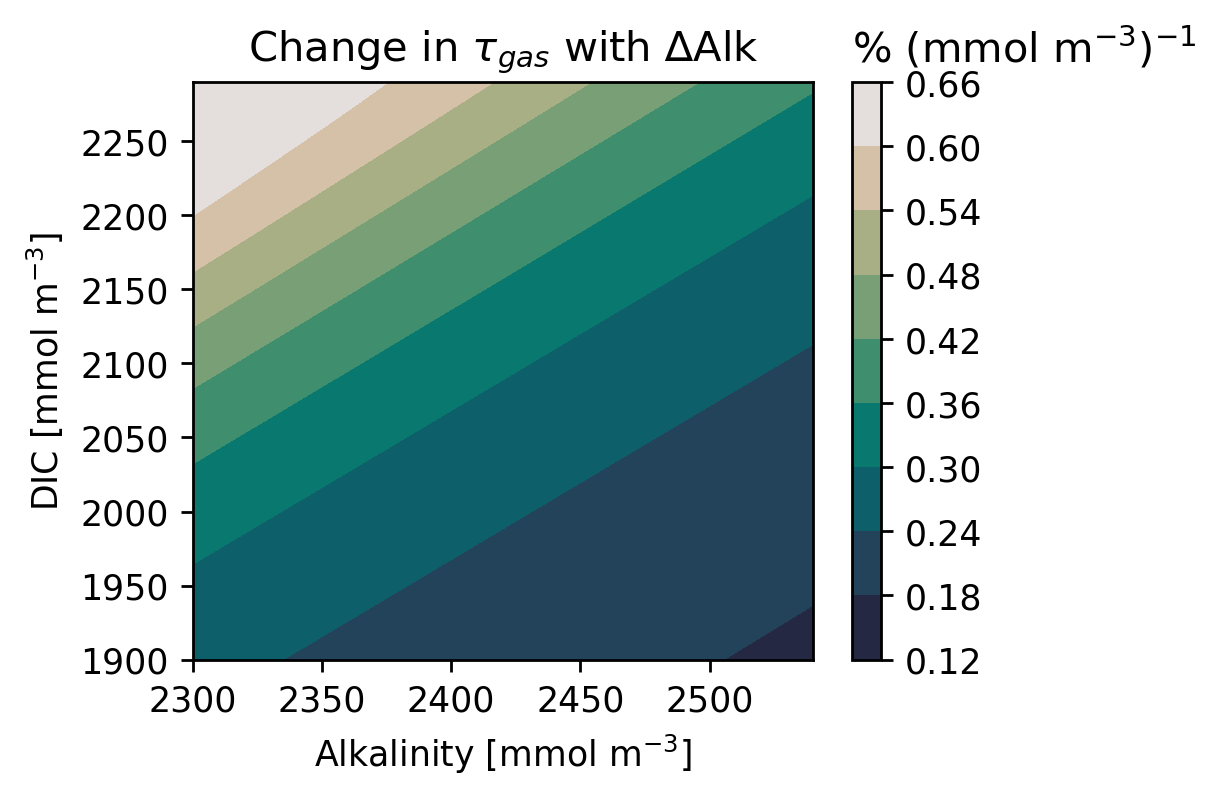

In [115]:
plt.figure(figsize=(4,3),dpi=250)

cf = plt.contourf(
    ds.alk,
    ds.dic,
    ds.dtau_dalk,
    cmap=cmocean.cm.rain_r,
)
cb = plt.colorbar(cf)
cb.ax.set_title("% (mmol m$^{-3}$)$^{-1}$", loc="left")
plt.xlabel("Alkalinity [mmol m$^{-3}$]")
plt.ylabel("DIC [mmol m$^{-3}$]")
plt.title("Change in $\\tau_{gas}$ with ∆Alk");

In [116]:
del client
del cluster
print('done')

done


## Repeating with GLODAP data

In [88]:
ds = glodap.open_glodap(product='GLODAPv2.2016b_MappedClimatologies')

# subset for surface
ds = ds.isel(depth=0, drop=True)
state = box_model.calc_csys(
    ds.DIC, ds.ALK, ds.SALT, ds.TEMP, flavor="pyco2sys"
)

In [94]:
def compute_eta(dic, alk, delta_alk):
    state.solve_co2(dic, alk)
    delta_dic =  state.calc_new_dic_w_oae(alk + delta_alk) - dic

    return delta_dic / delta_alk, np.nanmean([state.ddicdco2(dic, alk + delta_alk),state.ddicdco2(dic + delta_dic, alk + delta_alk)])

a1,b1 = compute_eta(ds.DIC,ds.ALK, 1)
a100,b100 = compute_eta(ds.DIC,ds.ALK, 100)

Text(0.5, 1.0, '$\\eta_{max}$ difference  ∆ALK=100 vs. 1 mmol/m$^3$')

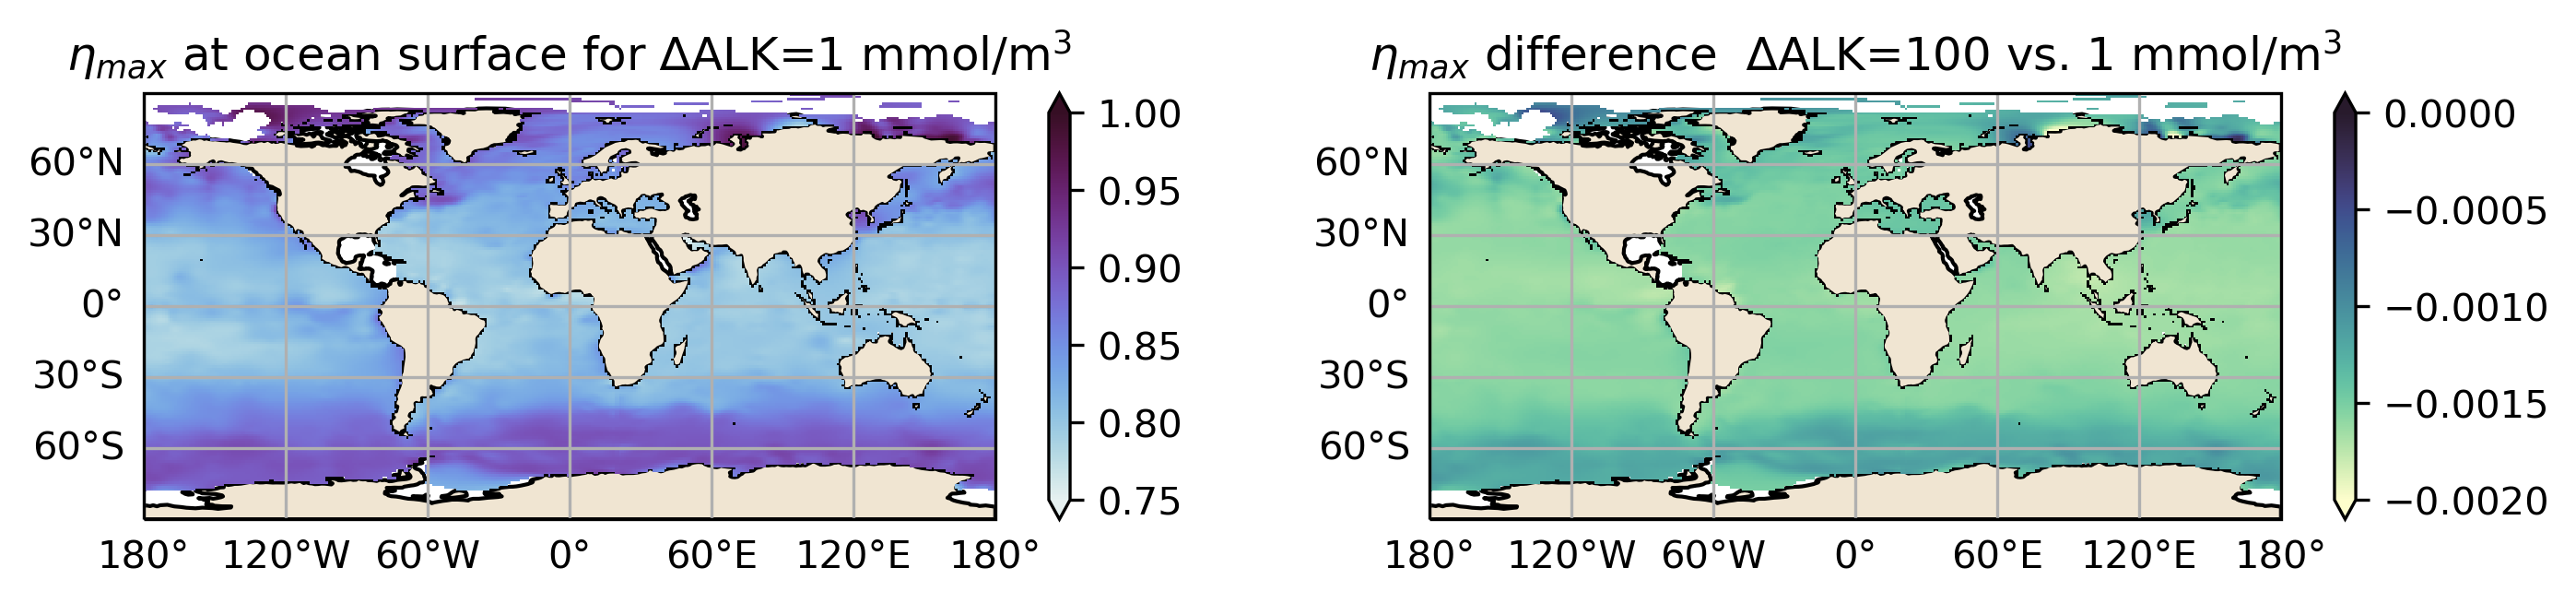

In [100]:
plt.figure(figsize = (11, 2),dpi=300)
ax1 = plt.subplot(1,2,1, projection=cartopy.crs.PlateCarree())
ax2 = plt.subplot(1,2,2, projection=cartopy.crs.PlateCarree())

ax1.add_feature(cartopy.feature.LAND, facecolor='#F0E5D2', edgecolor='black')
gl=ax1.gridlines(draw_labels=True); gl.top_labels = False; gl.right_labels = False

a1.plot(cmap=cmocean.cm.dense,ax=ax1,vmin=0.75,vmax=1,extend='both',cbar_kwargs={'label': ""})
ax1.set_title('$\eta_{max}$ at ocean surface for ∆ALK=1 mmol/m$^3$')

ax2.add_feature(cartopy.feature.LAND, facecolor='#F0E5D2', edgecolor='black')
gl=ax2.gridlines(draw_labels=True); gl.top_labels = False; gl.right_labels = False

(a100-a1).plot(cmap=cmocean.cm.deep,ax=ax2,vmin=-0.002,vmax=0,extend='both',cbar_kwargs={'label': ""})
ax2.set_title('$\eta_{max}$ difference  ∆ALK=100 vs. 1 mmol/m$^3$')


#plt.subplot(1,2,2)
#plt.tight_layout()

In [51]:
# plt.figure(figsize = (11, 2),dpi=300)
# ax1 = plt.subplot(1,2,1, projection=cartopy.crs.PlateCarree())
# ax2 = plt.subplot(1,2,2, projection=cartopy.crs.PlateCarree())

# ax1.add_feature(cartopy.feature.LAND, facecolor='#F0E5D2', edgecolor='black')
# gl=ax1.gridlines(draw_labels=True); gl.top_labels = False; gl.right_labels = False

# b1.plot(cmap=cmocean.cm.dense,ax=ax1,vmin=0,vmax=3,extend='both',cbar_kwargs={'label': ""})
# ax1.set_title('$\kappa$ at ocean surface for ∆ALK=1 mmol/m$^3$')

# ax2.add_feature(cartopy.feature.LAND, facecolor='#F0E5D2', edgecolor='black')
# gl=ax2.gridlines(draw_labels=True); gl.top_labels = False; gl.right_labels = False

# (b500-b1).plot(cmap=cmocean.cm.deep,ax=ax2,vmin=0,vmax=3,extend='both',cbar_kwargs={'label': ""})
# ax2.set_title('$\kappa$ difference')
